# Introduction

For my capstone project, I wanted to participate in Numerai's weekly data science competition. Numerai provides participants with cleaned, regularized, and obfuscated data to make predictions on that they then combine to steer their hedgefund investments. Because the is obfuscated, prior knowledge or research is not applicable. 

Submissions measured on three metrics: logarithmic loss, consistency (across eras), and concordance (consistency across datasets): 
- Compared to accuracy, lograithmic loss accounts uncertainty in predictions and penalizes based on how far off your predicted probability is from the correct class. Logarithmic loss ranges from 0 to 1, with 0 being the best possible score. The baseline for the Numerai competition is <0.693. 
- Consistency is a measure developed by Numerai to assess how well your model performs across eras. They are looking for models that perform consistently well across all eras in the test set. Numerai will reject your submission if this comes back below 58%. 
- Finally, concordance is an assessment that the same model has made predictions for each data set. You are provided the targets for the validation set, but this is what is displayed in the public leaderboard as well, so someone could just copy these and appear to publicly have the best model. Numerai keeps the predictions on the test set to internally assess the performance of the model and determine how to weight it for their investments. The live dataset is used for making investments and determining the eventual payout (at which time it becomes public).

I found this project to be incredibly challenging and I am happy that I was able to try new approaches and techniques that I previously hadn't had experience with before, including dealing with large datasets, create feature engineering, principal component analysis, and model ensembling with multiple underlying models. 

Below, I've detailed my approach including EDA, feature engineering, selection, and extraction, modeling, results, and predictions. For reference, this analysis is for the Bernie #115 competition. Please let me know if you have any questions. You can reach me at joedorfman@gmail.com. I would love to hear from you!

In [1]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer, QuantileTransformer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn import svm
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import log_loss 
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from mlens.ensemble import SuperLearner
from mlens.preprocessing import Subset
from mlens.model_selection import Evaluator

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.simplefilter("ignore")
%matplotlib inline 

[MLENS] backend: threading


In [2]:
# #options to display more data, was helpful at a few points but could be toggled off
# pd.set_option('display.max_rows', 200)
# pd.set_option('display.max_columns', 200)

# Import data

Data is provided by Numerai. There are two main datasets: training data and tournament data. As highlighted above, tournament data consists of three subsets: validation data, test data, and live data. 

I was having a few issues around memory, so I've imported these files with int8 and float16 data types. This helped things run faster and avoid kernal failures. 

In [3]:
#set datatype dictionary before import to reduce memory requirements
data_type = {'target_bernie':np.int8, 'target_charles':np.int8,'target_elizabeth':np.int8,'target_jordan':np.int8, 'target_ken':np.int8}
for j in range(1,51):
    data_type['feature' + str(j)] = np.float16

#import data 
train_data = pd.read_csv('numerai_training_data.csv', header=0, dtype=data_type)
tournament_data = pd.read_csv('numerai_tournament_data.csv', header=0)

# EDA

The data consists of 58 columns, 50 of which are the obfuscated features (labeled feature1-50), an id, a data type (train, validation, test, live), and some element of time, represented by eras. I first created a factorized era to be able to understand the data better (e.g. how many eras does each set of data represent) and better visualize what is going on. Later on, the factorized era will allow me to create features based on era values. 

I also needed to check if the ids were consistent at all to determine what type of model I would create. Since the ids are not consistent across eras this is not traditional time series analysis. 

Additionally, there are five different target columns with labels present in the train and validation data. You are required to submit probababilities for the validation, test, and live datasets for the competition. Since you can submit for each target separately, I've decided to only try 'target_bernie' for my intial submission. 

Most of the features plotted versus one another just look like blobs with limited discernable relationships or grouping based on target labels. I've included one plot with two features that illustrates this. 

Finally, I needed to take a look at the distributions of each from each dataset. It seems that earlier in Numerai's existance there were cases where the train and tournament sets had starkly different distributions, so folks empolyed an adversarial validation approach to select train data that most resembles the test data. However, this does not seem to be the case at leaset in this round as the distibutions look very similar (image below is all on the same scale). 

In [4]:
#create function to provide a numerical value for era
def factorize_era(df_train, df_test):
    combined_data = pd.concat([df_train, df_test]) #combine train and tournament data to maintain order of eras
    mask = combined_data['data_type'] == 'train' #create mask to split data later
    combined_data['factorized_era'] = pd.factorize(combined_data['era'])[0] #factorize era values
    
    for j in range(1,51):
            current_feature = 'feature' + str(j)
            combined_data[current_feature] = combined_data[current_feature].astype(np.float16) #convert to float16 to reduce memory
    
    #split data back into train and tournament 
    df1 = combined_data[mask] 
    df2 = combined_data[~mask]
    
    return df1, df2

train_data, tournament_data = factorize_era(train_data, tournament_data)

In [5]:
#wrote a quick function to see if this was time series data
def test_if_ids_repeat(df_train, df_test):
    id_test = pd.concat([df_train, df_test]) #combine datasets
    if id_test['id'].duplicated().sum() > 0: #see if ids repeat and return answer
        print('repeated ids')
    else:
        print('no repeated ids')
        
test_if_ids_repeat(train_data, tournament_data)

no repeated ids


In [6]:
#split tournament data over data types for data exploration and visualization 
validation_data = tournament_data[tournament_data['data_type'] == 'validation']
test_data = tournament_data[tournament_data['data_type'] == 'test']
live_data = tournament_data[tournament_data['data_type'] == 'live']

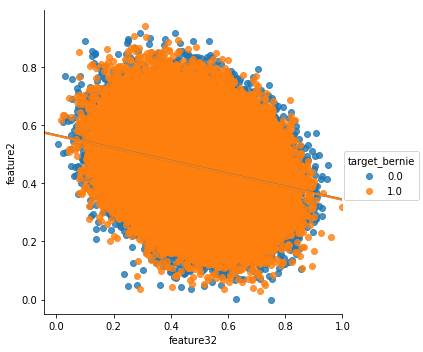

In [7]:
#plot two highest importance original features (found below), apply hue of target, and see if any pattern I can discern 
sns.lmplot(x='feature32', y='feature2', data=train_data, hue='target_bernie');

Plot of the two features from the original data set. No discernable grouping is visible

In [8]:
#going to first start with target bernie and move on to others if there is time
#pretty even split between classes
train_data['target_bernie'].value_counts(normalize=True)

0.0    0.500077
1.0    0.499923
Name: target_bernie, dtype: float64

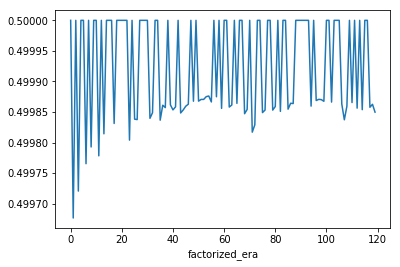

In [9]:
#quick visulization of probability over era, slight increase over eras
train_data.groupby(by='factorized_era').mean()['target_bernie'].plot()

Slight increase in probability over eras. I limited my time lagged features below as to account for this, as for each time lag I would need to drop data. 

In [10]:
train_data.shape

(393613, 59)

In [11]:
train_data.head()

id   era data_type  feature1  feature2  feature3  feature4  \
0  n2b2e3dd163cb422  era1     train  0.434814  0.446533  0.258057  0.371582   
1  n177021a571c94c8  era1     train  0.500488  0.392090  0.384033  0.512207   
2  n7830fa4c0cd8466  era1     train  0.474121  0.341309  0.395264  0.463379   
3  nc594a184cee941b  era1     train  0.487549  0.559082  0.439941  0.388428   
4  n85e624e4714a4ca  era1     train  0.624512  0.726074  0.740723  0.330078   

   feature5  feature6  feature7       ...        feature47  feature48  \
0  0.622559  0.674316  0.681152       ...         0.579590   0.496582   
1  0.366699  0.468994  0.682129       ...         0.455811   0.809082   
2  0.729492  0.459717  0.478760       ...         0.806152   0.392578   
3  0.446533  0.463867  0.707520       ...         0.624512   0.528809   
4  0.482178  0.437744  0.636230       ...         0.481445   0.770996   

   feature49  feature50  target_bernie  target_charles  target_elizabeth  \
0   0.489746   0.541992            1.0             1.0               1.0   
1   0.502930   0.616211            0.0             0.0               0.0   
2   0.418213   0.586914            0.0             0.0               0.0   
3   0.489990   0.495605            0.0             0.0               0.0   
4   0.397217   0.513672            0.0             0.0               0.0   

   target_jordan  target_ken  factorized_era  
0            1.0         1.0               0  
1            0.0         0.0               0  
2            0.0         0.0               0  
3            0.0         0.0               0  
4            0.0         0.0               0  

[5 rows x 59 columns]

In [12]:
print(train_data['factorized_era'].min())
print(train_data['factorized_era'].max())

0
119


In [13]:
validation_data.shape

(46362, 59)

In [14]:
validation_data.head()

id     era   data_type  feature1  feature2  feature3  \
0  n11e4e75a628d4d2  era121  validation  0.669922  0.490234  0.434326   
1  n6b1c334c5a164d4  era121  validation  0.732422  0.381104  0.540527   
2  nd6bef2176eb940d  era121  validation  0.611328  0.388184  0.559570   
3  n06f8a363410f448  era121  validation  0.191406  0.458740  0.683594   
4  na2e380f88ca64c4  era121  validation  0.466797  0.511230  0.637207   

   feature4  feature5  feature6  feature7       ...        feature47  \
0  0.255615  0.515625  0.651367  0.741699       ...         0.690918   
1  0.477051  0.689941  0.617188  0.503418       ...         0.484619   
2  0.370117  0.584473  0.534180  0.491699       ...         0.333740   
3  0.559082  0.466797  0.419189  0.313232       ...         0.576660   
4  0.361816  0.573242  0.459473  0.478027       ...         0.502930   

   feature48  feature49  feature50  target_bernie  target_charles  \
0   0.722168   0.505859   0.520996            0.0             0.0   
1   0.610840   0.525391   0.579102            0.0             0.0   
2   0.401367   0.368652   0.560059            1.0             1.0   
3   0.389893   0.385010   0.735352            1.0             1.0   
4   0.656738   0.397949   0.202026            1.0             1.0   

   target_elizabeth  target_jordan  target_ken  factorized_era  
0               0.0            0.0         0.0             120  
1               0.0            0.0         0.0             120  
2               1.0            1.0         1.0             120  
3               1.0            1.0         1.0             120  
4               1.0            1.0         1.0             120  

[5 rows x 59 columns]

In [15]:
print(validation_data['factorized_era'].min())
print(validation_data['factorized_era'].max())

120
131


In [16]:
test_data.shape

(192605, 59)

In [17]:
test_data.head()

id     era data_type  feature1  feature2  feature3  \
46362  n43fa05ca847941c  era133      test  0.366455  0.495117  0.715332   
46363  nf977c548efcc4b5  era133      test  0.565918  0.347656  0.271973   
46364  n119bfd82889d470  era133      test  0.447021  0.578613  0.530273   
46365  n76b0b5edc92746b  era133      test  0.390869  0.422607  0.673828   
46366  n106c2743763447d  era133      test  0.536133  0.561523  0.607422   

       feature4  feature5  feature6  feature7       ...        feature47  \
46362  0.475586  0.257324  0.587402  0.395752       ...         0.584473   
46363  0.396729  0.628906  0.487305  0.593262       ...         0.600098   
46364  0.504395  0.117126  0.356201  0.350830       ...         0.512695   
46365  0.423584  0.572754  0.556152  0.372803       ...         0.437256   
46366  0.394775  0.434082  0.434570  0.426025       ...         0.385742   

       feature48  feature49  feature50  target_bernie  target_charles  \
46362   0.476318   0.363037   0.312256            NaN             NaN   
46363   0.509766   0.586914   0.476318            NaN             NaN   
46364   0.577148   0.617188   0.343506            NaN             NaN   
46365   0.391602   0.543457   0.674316            NaN             NaN   
46366   0.706055   0.695801   0.504883            NaN             NaN   

       target_elizabeth  target_jordan  target_ken  factorized_era  
46362               NaN            NaN         NaN             132  
46363               NaN            NaN         NaN             132  
46364               NaN            NaN         NaN             132  
46365               NaN            NaN         NaN             132  
46366               NaN            NaN         NaN             132  

[5 rows x 59 columns]

In [18]:
print(test_data['factorized_era'].min())
print(test_data['factorized_era'].max())

132
176


In [19]:
live_data.shape

(4295, 59)

In [20]:
live_data.head()

id   era data_type  feature1  feature2  feature3  \
238967  ne413e83856e64c1  eraX      live  0.741699  0.367432  0.748047   
238968  n3ba8b63f12f84d7  eraX      live  0.246216  0.459229  0.398926   
238969  n142e0378e314433  eraX      live  0.427490  0.358154  0.336670   
238970  n9843118b3193428  eraX      live  0.510254  0.446289  0.665039   
238971  n1119865e4957468  eraX      live  0.653320  0.387451  0.406250   

        feature4  feature5  feature6  feature7       ...        feature47  \
238967  0.353271  0.570801  0.579590  0.500488       ...         0.468750   
238968  0.577148  0.373535  0.175171  0.512207       ...         0.527344   
238969  0.469482  0.540039  0.494385  0.510742       ...         0.343506   
238970  0.610840  0.542969  0.473877  0.427490       ...         0.446533   
238971  0.334473  0.544434  0.624512  0.458252       ...         0.568359   

        feature48  feature49  feature50  target_bernie  target_charles  \
238967   0.625977   0.473389   0.449951            NaN             NaN   
238968   0.603516   0.500488   0.599121            NaN             NaN   
238969   0.712402   0.786133   0.509277            NaN             NaN   
238970   0.397949   0.361084   0.519043            NaN             NaN   
238971   0.474854   0.471680   0.617188            NaN             NaN   

        target_elizabeth  target_jordan  target_ken  factorized_era  
238967               NaN            NaN         NaN             177  
238968               NaN            NaN         NaN             177  
238969               NaN            NaN         NaN             177  
238970               NaN            NaN         NaN             177  
238971               NaN            NaN         NaN             177  

[5 rows x 59 columns]

In [21]:
print(live_data['factorized_era'].min())
print(live_data['factorized_era'].max())

177
177


In [22]:
fig, ax = plt.subplots(50, 4, figsize=(100, 500), sharex=True, sharey=True)

for i in range(50):
    current_feature ='feature' + str(i+1)
    ax[i,0].set_title(str(current_feature) + ', train_data', fontsize=45)
    sns.distplot(train_data[current_feature], ax=ax[i,0], color='r')
    ax[i,1].set_title(str(current_feature) + ', validation_data', fontsize=45)
    sns.distplot(validation_data[current_feature], ax=ax[i,1], color='g')
    ax[i,2].set_title(str(current_feature) + ', test_data', fontsize=45)
    sns.distplot(test_data[current_feature], ax=ax[i,2], color='b')
    ax[i,3].set_title(str(current_feature) + ', live_data', fontsize=45)
    sns.distplot(live_data[current_feature], ax=ax[i,3], color='m');

Plot of the distributions of each feature for each subset of data. This was to check that the distributions are similar and I didn't have to employ adversarial validation like others previously. The data is plotted on the same scale for each graph above. The rough shape of the live data curves is likely due to it having significantly less data. 

# Feature Engineering

I spent a good amount of time thinking about features I could design based on the unique attributes of the dataset. The three categories I came up with were scaling data by era, comparing data within eras, and time lagged comparison between eras. For the later two, I used the mean, minimum, and maximum values for each feature within each era to compute ratios for each row. Each of these took some time to code up, so I was happy to see that there was a good variety when I did feature importance below!

One thing I should call out was my approach when the minimum value for a feature was zero. In this case, I would get infinite values which cause many issues. I decided the best approach was to use a very small value for the minimum (.0001) so I could still use these ratios. 

In the end, I ended up with 604 features from the original 50. I decided to run a quick model to narrow down to the 50 most important features.

In [23]:
#create list of feature names for use in feature engineering functions
feature_list = [cols for cols in train_data.columns if 'feature' in cols]

In [24]:
#create function to apply different scalers to each era 
def scale_data_by_era(df, scaler):
    feature_list_scaled = [cols + '_scaled_' + str(scaler)[:3] for cols in feature_list] #create list of new column titles
    scaled_data = [] #empty list to append scaled data to
    
    for i in df['factorized_era'].unique(): #iterate through each era 
        mask = df['factorized_era'] == i #create mask for each era, then fit and transform the data 
        scaled_data.append(pd.DataFrame(scaler.fit_transform(df.loc[mask, feature_list]), columns=feature_list_scaled))
        
    df2 = pd.concat(scaled_data) #create dataframe from newly scaled data from all eras
    df2.reset_index(drop=True, inplace=True) 
    df2 = df2.astype(np.float16)
    df = pd.concat([df, df2], axis=1) #concatinate new features with original dataset 
    
    return df

train_data = scale_data_by_era(train_data, Normalizer())
tournament_data = scale_data_by_era(tournament_data, Normalizer())
train_data = scale_data_by_era(train_data, RobustScaler())
tournament_data = scale_data_by_era(tournament_data, RobustScaler())

In [25]:
#create function to provide a numerical value for era
def factorize_era(df_train, df_test):
    combined_data = pd.concat([df_train, df_test]) #combine train and tournament data to maintain order of eras
    mask = combined_data['data_type'] == 'train' #create mask to split data later
    combined_data['factorized_era'] = pd.factorize(combined_data['era'])[0] #factorize era values
    
    for j in range(1,51):
            current_feature = 'feature' + str(j)
            combined_data[current_feature] = combined_data[current_feature].astype(np.float16) #convert to float16 to reduce memory
    
    #split data back into train and tournament 
    df1 = combined_data[mask] 
    df2 = combined_data[~mask]
    
    return df1, df2

train_data, tournament_data = factorize_era(train_data, tournament_data)

In [26]:
#create function to add mean, min, max ratios for each era 
def add_ratios(df_train, df_test):
    df = pd.concat([df_train, df_test]) #combine train and tournament data to maintain order of eras
    mask_train = df['data_type'] == 'train' #create mask to split data later

    #create groupby dataframes for mean, min, max
    means = df.groupby(by='factorized_era').mean()
    mins = df.groupby(by='factorized_era').min() 
    maxs = df.groupby(by='factorized_era').max()
    
    for i in means.index:                   #iterate through each era
        mask = df['factorized_era'] == i
        for j in range(1,51):               #iterate through each feature
            current_feature = 'feature' + str(j) 

            if mins.loc[i, current_feature] != 0:       #ran into issues with infinite values so need to check if the min value for an era is 0
                #create ratio for each era
                df.loc[mask, str(current_feature) + '_mean_ratio'] = df.loc[mask, current_feature] / means.loc[i, current_feature]
                df.loc[mask, str(current_feature) + '_min_ratio'] = df.loc[mask, current_feature] / mins.loc[i, current_feature]
                df.loc[mask, str(current_feature) + '_max_ratio'] = df.loc[mask, current_feature] / maxs.loc[i, current_feature]
                
                #convert float 16
                df[current_feature + '_mean_ratio'] = df[current_feature + '_mean_ratio'].astype(np.float16)
                df[current_feature + '_min_ratio'] = df[current_feature + '_min_ratio'].astype(np.float16)
                df[current_feature + '_max_ratio'] = df[current_feature + '_max_ratio'].astype(np.float16)
            
            else:                   #when min value for an era is 0, divide by value near 0
                df.loc[mask, str(current_feature) + '_mean_ratio'] = df.loc[mask, current_feature] / means.loc[i, current_feature]
                df.loc[mask, str(current_feature) + '_max_ratio'] = df.loc[mask, current_feature] / maxs.loc[i, current_feature]

                df.loc[mask, str(current_feature) + '_min_ratio'] = df.loc[mask, current_feature] / .0001
                   
                df[current_feature + '_mean_ratio'] = df[current_feature + '_mean_ratio'].astype(np.float16)
                df[current_feature + '_min_ratio'] = df[current_feature + '_min_ratio'].astype(np.float16)
                df[current_feature + '_max_ratio'] = df[current_feature + '_max_ratio'].astype(np.float16)
                
    #split data back into train and tournament 
    df1 = df[mask_train] 
    df2 = df[~mask_train]
    
    return df1, df2

train_data, tournament_data = add_ratios(train_data, tournament_data)

In [27]:
#create time lagged versions of ratio above
def add_shifts(df_train, df_test, shift_amount): #get shift amount 
    df = pd.concat([df_train, df_test]) #combine train and tournament data to maintain order of eras
    mask_train = df['data_type'] == 'train' #create mask to split data later
    
    means = df.groupby(by='factorized_era').mean()
    mins = df.groupby(by='factorized_era').min() 
    maxs = df.groupby(by='factorized_era').max()
    for i in means.index:
        if i > shift_amount:    #eras less than i will be dropped, so only going to do 1 or 2. without this, hit an error 
            mask = df['factorized_era'] == i
            for j in range(1,51):
                current_feature = 'feature' + str(j)
                
                if mins.loc[i-shift_amount, current_feature] != 0: #same concept as previous function, need to check if this is 0 to avoid infinite values
                    #shifted the mean, min, max by shift_amount
                    df.loc[mask, str(current_feature) + '_mean_ratio_shift_' + str(shift_amount)] = df.loc[mask, current_feature] / means.loc[i-shift_amount, current_feature]
                    df.loc[mask, str(current_feature) + '_min_ratio_shift_' + str(shift_amount)] = df.loc[mask, current_feature] / mins.loc[i-shift_amount, current_feature]
                    df.loc[mask, str(current_feature) + '_max_ratio_shift_' + str(shift_amount)] = df.loc[mask, current_feature] / maxs.loc[i-shift_amount, current_feature]

                    df[current_feature + '_mean_ratio_shift_' + str(shift_amount)] = df[current_feature + '_mean_ratio_shift_' + str(shift_amount)].astype(np.float16)
                    df[current_feature + '_min_ratio_shift_' + str(shift_amount)] = df[current_feature + '_min_ratio_shift_' + str(shift_amount)].astype(np.float16)
                    df[current_feature + '_max_ratio_shift_' + str(shift_amount)] = df[current_feature + '_max_ratio_shift_' + str(shift_amount)].astype(np.float16)

                else:      #same as function above, if min of an era is 0, use value close to 0
                    df.loc[mask, str(current_feature) + '_mean_ratio_shift_' + str(shift_amount)] = df.loc[mask, current_feature] / means.loc[i-shift_amount, current_feature]
                    df.loc[mask, str(current_feature) + '_max_ratio_shift_' + str(shift_amount)] = df.loc[mask, current_feature] / maxs.loc[i-shift_amount, current_feature]

                    df.loc[mask, str(current_feature) + '_min_ratio_shift_' + str(shift_amount)] = df.loc[mask, current_feature] / .0001
                    
                    df[current_feature + '_mean_ratio_shift_' + str(shift_amount)] = df[current_feature + '_mean_ratio_shift_' + str(shift_amount)].astype(np.float16)
                    df[current_feature + '_min_ratio_shift_' + str(shift_amount)] = df[current_feature + '_min_ratio_shift_' + str(shift_amount)].astype(np.float16)
                    df[current_feature + '_max_ratio_shift_' + str(shift_amount)] = df[current_feature + '_max_ratio_shift_' + str(shift_amount)].astype(np.float16)
    
    #split data back into train and tournament 
    df1 = df[mask_train] 
    df2 = df[~mask_train]
    
    return df1, df2

train_data, tournament_data = add_shifts(train_data, tournament_data, 1)
train_data, tournament_data = add_shifts(train_data, tournament_data, 2)

In [28]:
#split tournament data over data types again
validation_data = tournament_data[tournament_data['data_type'] == 'validation']
test_data = tournament_data[tournament_data['data_type'] == 'test']
live_data = tournament_data[tournament_data['data_type'] == 'live']

In [29]:
train_data.shape

(393613, 609)

In [30]:
# train_data.to_csv('updated_train_data.csv') #save data to avoid having to rerun these again
# train_data = pd.read_csv('updated_train_data.csv')

# Feature Selection/Extraction

I created a XGB Classifier model to quickly determine the feature importances and select the top 50 new features. I was happy to see a nice diversity in the top 50 features including a good amount of my engineered features. Since I will be running PCA after this, this process was the only real interprebility I have of the features. I ended up pickling the model below so that I didn't have to rerun it a bunch of times. In the future, I may also run a logistic regression model and add the features with highest coefficients from that model as well. I have seen this return very different features than a tree based model, so could be affecting my performance in the modeling portion below. 

After selecting the top 50 features, I wanted to run PCA. PCA is a statistical technique to extract new features that maximize variance amongst features will reducing covariance. Since many of my features are derived from the original set of features, I thought PCA would be helpful to run while also reducing my dimensions to decrease run time. I reduced the number of features from the top 50 to 28 because that is where the 90% threshold of explained variance occurred. This means that I was able to maintain 90% of the variance of my features will reducing the number of features by half. I may go back later and try my final models without PCA to assess any impacts on performance. I also wanted to try a few other techniques, including polynomial features and LDA, but decided against including those for a variety of reasons. Mainly, polynomial features significantly increased my run time and LDA may be valuable as a new feature going forward, but I wasn't able to include it due to time constraints. 

In [31]:
#ModelTransformer class built by my awesome teacher Adam! allows for multiple scalers to be used in a pipeline. 
#source can be found here: https://blomadam.github.io/

class ModelTransformer(BaseEstimator,TransformerMixin):

    def __init__(self, model=None):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return self.model.transform(X)
    

In [32]:
#isolate target_bernie, drop nas, and split data into X and y. this will be for intial model to get top 100 features
train_data_bernie = train_data.drop(['target_charles', 'target_elizabeth', 'target_jordan', 'target_ken'], axis=1)
train_data_bernie.dropna(inplace=True)
X = train_data_bernie.drop(['id','data_type','target_bernie','era'], axis=1) 
y = train_data_bernie['target_bernie']

In [95]:
X_validation_test = validation_data.drop(['id','data_type','target_bernie','era','target_charles', 'target_elizabeth', 'target_jordan', 'target_ken'], axis=1)
y_validation_test = validation_data['target_bernie']

In [98]:
#manual tuning of XGBoost model (performed many interations of this but only left final parameters)
eval_set = [(X_validation_test, y_validation_test)] #eval set to calculate early stopping
#set model parameters, used large n_estimators because of the early stopping (i.e. this won't be reached)
xgb_model_test = xgb.XGBClassifier(n_estimators=1000, reg_alpha=10, random_state=1)

#fit model on training data and set eval metric to log loss
xgb_model_test.fit(X,y, early_stopping_rounds=20, eval_metric='logloss', eval_set=eval_set, verbose=True)

#predict on validation data and print score
preds_val_test = xgb_model_test.predict_proba(X_validation_test)
print('validation score:', log_loss(y_validation_test, preds_val_test[:,1]))

[0]	validation_0-logloss:0.693084
Will train until validation_0-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.693059
[2]	validation_0-logloss:0.69303
[3]	validation_0-logloss:0.693002
[4]	validation_0-logloss:0.693009
[5]	validation_0-logloss:0.692987
[6]	validation_0-logloss:0.692955
[7]	validation_0-logloss:0.69293
[8]	validation_0-logloss:0.692926
[9]	validation_0-logloss:0.692897
[10]	validation_0-logloss:0.692901
[11]	validation_0-logloss:0.692893
[12]	validation_0-logloss:0.692873
[13]	validation_0-logloss:0.692857
[14]	validation_0-logloss:0.692837
[15]	validation_0-logloss:0.692824
[16]	validation_0-logloss:0.692818
[17]	validation_0-logloss:0.6928
[18]	validation_0-logloss:0.69281
[19]	validation_0-logloss:0.692823
[20]	validation_0-logloss:0.692804
[21]	validation_0-logloss:0.692786
[22]	validation_0-logloss:0.692777
[23]	validation_0-logloss:0.692774
[24]	validation_0-logloss:0.692774
[25]	validation_0-logloss:0.692781
[26]	validation_0-logloss:0.692788
[2

In [33]:
# #XGB Classifier model to id top features. didn't need to make a pipeline but originally had more going on for this 
# pipeline = Pipeline([
#         ('scale', ModelTransformer()),
#         ('xgb', xgb.XGBClassifier(n_estimators=100, max_depth=10, random_state=1)),
# ])


# params = {
#     'scale__model': [StandardScaler()],
# }
    

# gs = GridSearchCV(pipeline, param_grid=params, scoring='log_loss')
# gs.fit(X,y)
# print('best cv score', gs.best_score_)
# print('best paramas', gs.best_params_)

In [34]:
#save best estimator and pickle model to avoid rerunning 
# imp_feature_model = gs.best_estimator_

#pickle/unpickle model below 
# modelfilename= 'imp_feature_model.sav'
# pickle.dump(imp_feature_model, open(modelfilename, 'wb'))

imp_feature_model = pickle.load(open('imp_feature_model.sav', 'rb'))

In [35]:
#create data frame of important features 
feature_importances = pd.DataFrame(X.columns, imp_feature_model.steps[1][1].feature_importances_.tolist()) #merge column headers and feature importances from saved model
feature_importances.reset_index(inplace=True)
feature_importances.rename({'index':'Feature Importance', 0:'Feature'}, axis=1, inplace=True)

important_features = feature_importances.sort_values(by='Feature Importance', ascending=False) #sort by feature importance
important_features[:50] #display top 50 features

Feature Importance                      Feature
31             0.006263                    feature32
263            0.005329          feature38_min_ratio
302            0.005000   feature1_min_ratio_shift_1
152            0.004965           feature1_min_ratio
548            0.004827  feature33_min_ratio_shift_2
4              0.004706                     feature5
12             0.004654                    feature13
398            0.004654  feature33_min_ratio_shift_1
7              0.004619                     feature8
5              0.004602                     feature6
1              0.004550                     feature2
164            0.004550           feature5_min_ratio
2              0.004515                     feature3
22             0.004481                    feature23
26             0.004429                    feature27
44             0.004394                    feature45
452            0.004360   feature1_min_ratio_shift_2
338            0.004325  feature13_min_ratio_shift_1
19             0.004325                    feature20
191            0.004308          feature14_min_ratio
170            0.004273           feature7_min_ratio
476            0.004273   feature9_min_ratio_shift_2
25             0.004273                    feature26
425            0.004239  feature42_min_ratio_shift_1
37             0.004239                    feature38
29             0.004239                    feature30
27             0.004221                    feature28
36             0.004221                    feature37
13             0.004204                    feature14
293            0.004187          feature48_min_ratio
24             0.004169                    feature25
35             0.004169                    feature36
488            0.004169  feature13_min_ratio_shift_2
6              0.004152                     feature7
0              0.004135                     feature1
18             0.004135                    feature19
17             0.004135                    feature18
593            0.004118  feature48_min_ratio_shift_2
88             0.004118         feature38_scaled_Nor
30             0.004100                    feature31
374            0.004083  feature25_min_ratio_shift_1
11             0.004066                    feature12
21             0.004048                    feature22
524            0.003996  feature25_min_ratio_shift_2
284            0.003979          feature45_min_ratio
8              0.003927                     feature9
42             0.003910                    feature43
23             0.003893                    feature24
14             0.003893                    feature15
179            0.003858          feature10_min_ratio

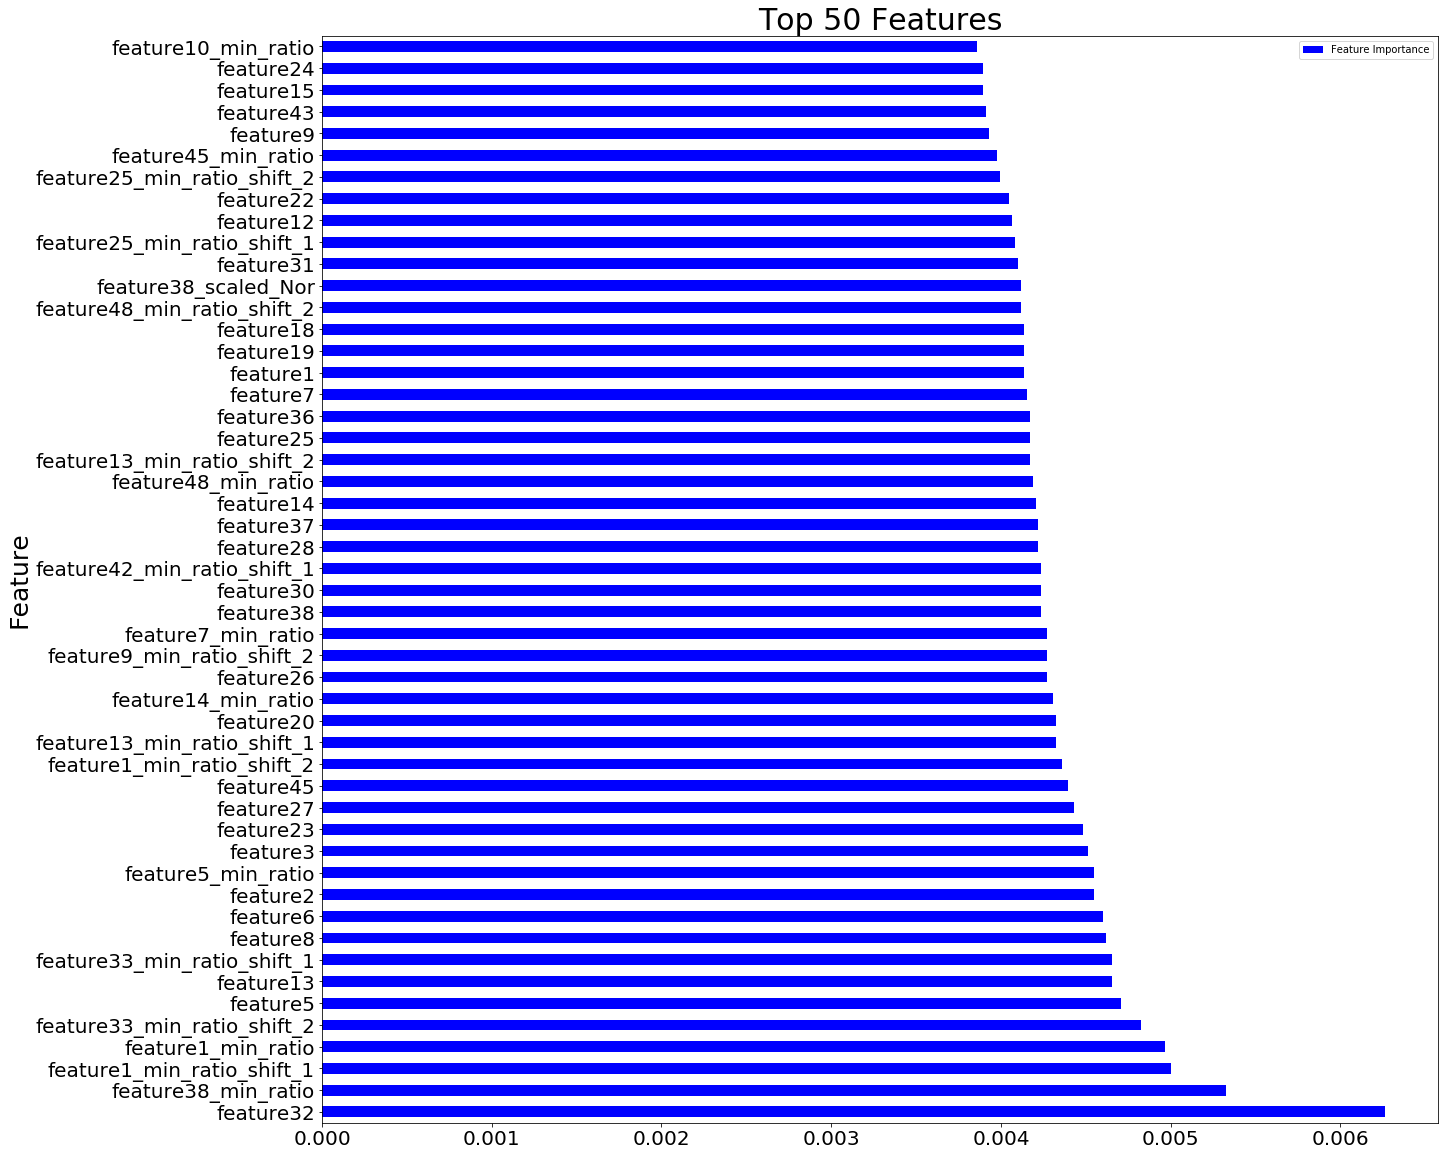

In [41]:
#plot top 50 features
important_features.sort_values(by='Feature Importance', ascending=False)[:50].plot(y='Feature Importance', 
                                                                                   x='Feature', 
                                                                                   kind='barh', 
                                                                                   figsize=(20,20), 
                                                                                   color='b', 
                                                                                   fontsize=20); 
plt.title('Top 50 Features', fontsize=30)
plt.ylabel('Feature', size = 25);

Plot of the 50 features with highest feature importance from XGBoost model. 

In [42]:
num_features = 50 #select how many features to keep
features_to_keep = important_features['Feature'][:num_features].tolist() #create list of selected amount of features
X_imp_features = train_data_bernie[features_to_keep] #create dataframe of those features 

In [43]:
#investigate PCA, will be used to determine parameter of underlying models in the voting classifier
ss = StandardScaler() 
incremental_pca = IncrementalPCA() 

Xs = ss.fit_transform(X_imp_features) #scale data

X_pca = incremental_pca.fit(Xs) #incremental pca better for larger data sets 

In [76]:
#calculate explained varience and id how many features are needed for 90% of the varience 
var_exp = X_pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp) #cumalative sum of the array of explained variance ratios 
number_of_features = np.where(cum_var_exp > .9)[0][0] #set number of features to where 90% of variance is captured

#print results
print(f'90% of the variance is captured in the first {number_of_features} features')
print(f'Out of a total of {len(cum_var_exp)} features')
print(f'Reduction of {((number_of_features/len(cum_var_exp))*100):.2f}% of features')

90% of the variance is captured in the first 28 features
Out of a total of 50 features
Reduction of 56.00% of features


In [45]:
#transform data 
X_transformed = X_pca.transform(Xs)

#create dataframe for transformed data 
features_pca = ['PC'+str(i+1) for i in range(X_pca.n_components_)]
df_test_pca = pd.DataFrame(X_transformed, columns=features_pca)

y.reset_index(drop=True, inplace=True)

#select number of pca features and combine with target in a dataframe
df_test_pca_reduced = pd.concat([df_test_pca.iloc[:, :number_of_features], y], axis=1)

In [46]:
cum_var_exp[1] #see how much of the variance is captured by first two features 

0.16412853291328966

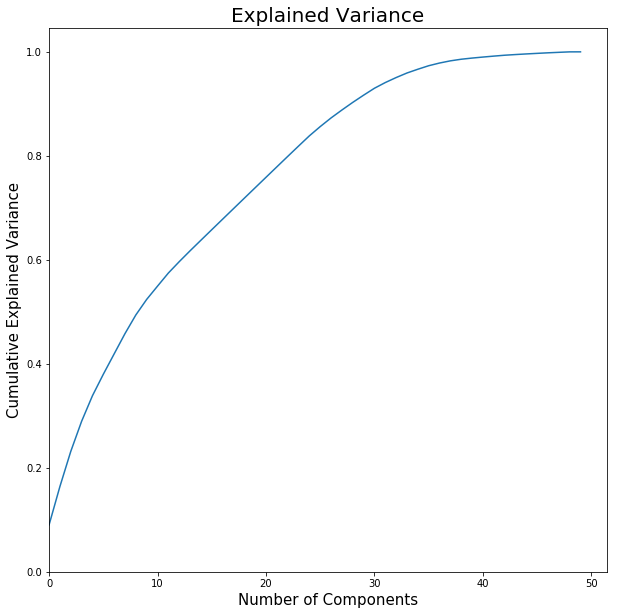

In [77]:
plt.figure(figsize=(10,10))
plt.plot(cum_var_exp)
plt.xlabel('Number of Components', size=15)
plt.ylabel('Cumulative Explained Variance', size=15)
plt.title('Explained Variance', size=20)
ax = plt.gca()
ax.set_ylim(ymin=0)
ax.set_xlim(xmin=0);

<Figure size 720x720 with 0 Axes>

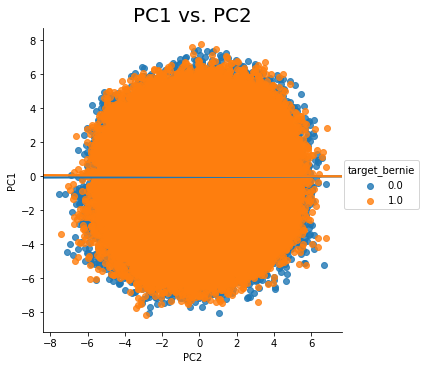

In [78]:
#plot PC1 vs PC2, apply hue of target, and see if any pattern has emerged 
plt.figure(figsize=(10,10))
sns.lmplot(x='PC2', y='PC1', data=df_test_pca_reduced, hue='target_bernie')
ax = plt.gca()
ax.set_title('PC1 vs. PC2', fontsize=20); 

Plot fo PC1 vs PC2. These are the two features with the highest explained variance, although they only account for 16.4% of explained variance. I was hoping to see a bit more separation of the classes here, but any change is pretty indiscernible. 

In [48]:
#create dataframes for the reduced features data set
X_bernie = df_test_pca_reduced.iloc[:, :-1] 
y_bernie = df_test_pca_reduced.iloc[:, -1:]
print(X_bernie.shape)
print(y_bernie.shape)

(388778, 28)
(388778, 1)


Played around with PolynomialFeatures and Linear Discriminant Analysis but didn't include them in my final project.

In [ ]:
# poly = PolynomialFeatures(interaction_only=True)

# X_poly = poly.fit_transform(X_bernie)
# df_X_bernie = pd.DataFrame(X_poly, columns=poly.get_feature_names(X_bernie.columns))
# df_X_bernie.head()

# print(y_bernie.shape)
# print(df_X_bernie.shape)

In [ ]:
# #investigate lda 
# X_lda = df_test_pca_reduced.iloc[:, :-1]
# y_lda = df_test_pca_reduced.iloc[:, -1:]

# # poly = PolynomialFeatures(interaction_only=True)
# lda = LinearDiscriminantAnalysis()

# # X_poly = poly.fit_transform(X_lda)
# df_lda = lda.fit(X_lda, y_lda).transform(X_lda)

# lda.explained_variance_ratio_

# Model - Ensemble Model (Base Learners & Meta-Estimator)

For the modeling portion, I wanted to try an ensemble approach as I have heard those are very accurate in these types of competitions. My approach was to determine the optimal parameters for six separate classifications models to serve as base learners: XGB Classifier, SGD Classifier, Logistic Regression, Gaussian Naive Bayes Classifier, and Adaboost Classifier. For each of these (except the XGBoost model), I used gridsearch to determine the optimal parameters and returned the score for the validation data. For the XGBoost model, I manually tune the parameters to take advantage of the early stopping capability, which I could not figure out how to use in gridsearch. Each of these models exhibits some overfitting to the training data, which with more time, I would try to reduce. For instance, I could increase the number of Kfolds I am using which would increase my runtime but potentially reduce the overfitting or perhaps eliminate the feature selection process above (may have selected too many features that predict the training set well but don't generalize). Additionally, the benchmark for log loss is <0.693 from Numerai, so none of the base learners met this threshold on the validation set. 

Once I found parameters for each base learner, I used the ML-Ensemble package to stack the models in one layer and combine it with a meta-estimator. I selected a logistic regression model for my meta-estimator. All of the models and parameters can be gridsearched via ML-Ensemble and may be an avenue I pursue in the future. 

In [49]:
strat_kfolds = StratifiedKFold(n_splits=2,shuffle=True,random_state=1) #stratified kfolds for cross validation

In [50]:
#manually perform feature selection, scaling, and PCA to avoid having to do it each time in the pipeline
X_validation = validation_data[features_to_keep] #
y_validation = validation_data['target_bernie']

X_val_imp_features_scaled = ss.transform(X_validation) #scale data with transform (already fit above)
X_val_pca_transformed = incremental_pca.transform(X_val_imp_features_scaled) #perform PCA (again, already fit above)

#create dataframe for transformed data 
X_val_pca = pd.DataFrame(X_val_pca_transformed, columns=features_pca)
X_val_pca = X_val_pca.iloc[:, :number_of_features]

For the XGBoost model, I tune a few parameters to reduce overfitting including reg_alpha (regularization), subsample, and colsample_bytree. I am still overfitting to the training data, so may need to reduce max_depth and take a hit on the score for the valdiation data. 

In [51]:
#manual tuning of XGBoost model (performed many interations of this but only left final parameters)
eval_set = [(X_val_pca, y_validation)] #eval set to calculate early stopping
#set model parameters, used large n_estimators because of the early stopping (i.e. this won't be reached)
xgb_model = xgb.XGBClassifier(n_estimators=1000, reg_alpha=10, max_depth=7, subsample=.5,colsample_bytree=.75, random_state=1)

#fit model on training data and set eval metric to log loss
xgb_model.fit(X_bernie,y_bernie, early_stopping_rounds=20, eval_metric='logloss', eval_set=eval_set, verbose=True)

#predict on validation data and print score
preds_val = xgb_model.predict_proba(X_val_pca)
print('validation score:', log_loss(y_validation, preds_val[:,1]))

[0]	validation_0-logloss:0.693087
Will train until validation_0-logloss hasn't improved in 20 rounds.
[1]	validation_0-logloss:0.693063
[2]	validation_0-logloss:0.693037
[3]	validation_0-logloss:0.692955
[4]	validation_0-logloss:0.692948
[5]	validation_0-logloss:0.692904
[6]	validation_0-logloss:0.692902
[7]	validation_0-logloss:0.692876
[8]	validation_0-logloss:0.692891
[9]	validation_0-logloss:0.692906
[10]	validation_0-logloss:0.69287
[11]	validation_0-logloss:0.692843
[12]	validation_0-logloss:0.692847
[13]	validation_0-logloss:0.692857
[14]	validation_0-logloss:0.692866
[15]	validation_0-logloss:0.69291
[16]	validation_0-logloss:0.692924
[17]	validation_0-logloss:0.69296
[18]	validation_0-logloss:0.692935
[19]	validation_0-logloss:0.692961
[20]	validation_0-logloss:0.692976
[21]	validation_0-logloss:0.693044
[22]	validation_0-logloss:0.69298
[23]	validation_0-logloss:0.693007
[24]	validation_0-logloss:0.693026
[25]	validation_0-logloss:0.693059
[26]	validation_0-logloss:0.693052
[

In [ ]:
# pipeline_xgb = Pipeline([
#         ('scale', ModelTransformer()),
#         ('fit', xgb.XGBClassifier(n_estimators=50, max_depth=7, reg_alpha=10, subsample=.5, colsample_bytree=.75, random_state=1)),
# ])


# params_xgb = {
#     'scale__model': [MinMaxScaler()],
# }

# gs1 = GridSearchCV(pipeline_xgb, param_grid=params_xgb, cv=strat_kfolds, scoring='neg_log_loss', verbose=1)
# gs1.fit(X_bernie,y_bernie)
# print('best cv score:', gs1.best_score_)
# print('best paramas:', gs1.best_params_)
# print('validation score:', gs1.score(X_val_pca, y_validation))

In [ ]:
# #pipeline and gridsearch for SVM model
# pipeline_svm = Pipeline([
#         ('scale', ModelTransformer()),
#         ('fit', svm.SVC(probability=True, random_state=1)),
# ])

# params_svm = {
#     'scale__model': [MinMaxScaler()],
#     'fit__kernel': ['rbf', 'sigmoid', 'linear', 'poly'],
#     'fit__C':[.05, 1, 2],
#     'fit__gamma':[.05, 1, 2],
# }
    

# gs1 = GridSearchCV(pipeline_svm, param_grid=params_svm, cv=strat_kfolds, scoring='neg_log_loss', verbose=1)
# gs1.fit(X_bernie,y_bernie)
# print('best cv score', gs1.best_score_)
# print('best paramas', gs1.best_params_)
# print('validation score:', gs1.score(X_val_pca, y_validation))

In [79]:
#pipeline and gridsearch for SGDC model
pipeline_sgd = Pipeline([
        ('scale', ModelTransformer()),
        ('fit', SGDClassifier(loss='log', random_state=1)),
])

params_sgd = {
    'scale__model': [MinMaxScaler()],
    'fit__penalty': ['l1', 'l2', 'elasticnet'],
    'fit__alpha':[0.0001, .001, .01],
    'fit__l1_ratio':[.05,.15,.25],
}
    

gs2 = GridSearchCV(pipeline_sgd, param_grid=params_sgd, cv=strat_kfolds, scoring='neg_log_loss', verbose=1)
gs2.fit(X_bernie,y_bernie)
print('best cv score', gs2.best_score_)
print('best paramas', gs2.best_params_)
print('validation score:', gs2.score(X_val_pca, y_validation))

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   46.4s finished


best cv score -0.6927753861517302
best paramas {'fit__alpha': 0.0001, 'fit__l1_ratio': 0.15, 'fit__penalty': 'elasticnet', 'scale__model': MinMaxScaler(copy=True, feature_range=(0, 1))}
validation score: -0.6932254651226964


In [67]:
#pipeline and gridsearch for logistic regression model
pipeline_logreg = Pipeline([
        ('scale', ModelTransformer()),
        ('fit', LogisticRegression(random_state=1)),
])

params_logreg = {
    'scale__model': [MinMaxScaler()],
    'fit__penalty':['l1','l2'],
    'fit__C':[1, 10, 50, 100],
    'fit__class_weight':[None,'balanced']
}
    

gs3 = GridSearchCV(pipeline_logreg, param_grid=params_logreg, cv=strat_kfolds, scoring='neg_log_loss', verbose=1)
gs3.fit(X_bernie,y_bernie)
print('best cv score', gs3.best_score_)
print('best paramas', gs3.best_params_)
print('validation score:', gs3.score(X_val_pca, y_validation))

Fitting 2 folds for each of 16 candidates, totalling 32 fits


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 29.7min finished


best cv score -0.6925842577924587
best paramas {'fit__C': 1, 'fit__class_weight': None, 'fit__penalty': 'l1', 'scale__model': MinMaxScaler(copy=True, feature_range=(0, 1))}
validation score: -0.6930140440174033


In [75]:
#save best estimator and pickle model to avoid rerunning 
logreg_model = gs3.best_estimator_

#pickle/unpickle model below 
modelfilename= 'logreg_model.sav'
pickle.dump(logreg_model, open(modelfilename, 'wb'))

# imp_feature_model = pickle.load(open('imp_feature_model.sav', 'rb'))

In [68]:
#pipeline and gridsearch for Naive Bayes model
pipeline_nb = Pipeline([
        ('scale', ModelTransformer()),
        ('fit', GaussianNB()),
])

params_nb = {
    'scale__model': [MinMaxScaler()],
}
    

gs4 = GridSearchCV(pipeline_nb, param_grid=params_nb, cv=strat_kfolds, scoring='neg_log_loss', verbose=1)
gs4.fit(X_bernie,y_bernie)
print('best cv score', gs4.best_score_)
print('best paramas', gs4.best_params_)
print('validation score:', gs4.score(X_val_pca, y_validation))

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.2s finished


best cv score -0.7535785814469337
best paramas {'scale__model': MinMaxScaler(copy=True, feature_range=(0, 1))}
validation score: -0.7002342433800876


In [72]:
# #set model parameters, used large n_estimators because of the early stopping (i.e. this won't be reached)
# ada_model = AdaBoostClassifier(n_estimators=100, learning_rate=.005, base_estimator=RandomForestClassifier(), random_state=1)

# #fit model on training data and set eval metric to log loss
# ada_model.fit(X_bernie,y_bernie)

# #predict on validation data and print score
# preds_val_ada = ada_model.predict_proba(X_val_pca)
# print('validation score:', log_loss(y_validation, preds_val_ada[:,1]))

In [73]:
# #pipeline and gridsearch for Adaboost model
# pipeline_ada = Pipeline([
#         ('scale', ModelTransformer()),
#         ('fit', AdaBoostClassifier(base_estimator=RandomForestClassifier(), random_state=1)),
# ])


# params_ada = {
#     'scale__model': [MinMaxScaler()],
#     'fit__n_estimators': [100],
#     'fit__learning_rate':[.005],
# }
    

# gs5 = GridSearchCV(pipeline_ada, param_grid=params_ada, cv=strat_kfolds, scoring='neg_log_loss', verbose=1)
# gs5.fit(X_bernie,y_bernie)
# print('best cv score:', gs5.best_score_)
# print('best paramas:', gs5.best_params_)
# print('validation score:', gs5.score(X_val_pca, y_validation))

In [74]:
# #save best estimator and pickle model to avoid rerunning 
# ada_model = gs5.best_estimator_

# #pickle/unpickle model below 
# modelfilename= 'ada_model.sav'
# pickle.dump(ada_model, open(modelfilename, 'wb'))

# # imp_feature_model = pickle.load(open('imp_feature_model.sav', 'rb'))

In [80]:
#select features to keep for tournament data
tournament_data_bernie = tournament_data[features_to_keep]

In [81]:
#create logloss function to return log loss score for ML-Ensemble
def logloss(y, preds):
    return log_loss(y, preds)

In [88]:
X_val = validation_data.drop(['id','era','data_type','target_charles', 'target_bernie','target_elizabeth', 'target_jordan', 'target_ken'],axis=1)

In [92]:
#set estimators as best parameters found above
xgb_model_ensemble = xgb.XGBClassifier(n_estimators=11, reg_alpha=10, max_depth=7, subsample=.5,colsample_bytree=.75, random_state=1)
sgd_model = SGDClassifier(loss='log', alpha= 0.0001, l1_ratio= 0.15, penalty= 'elasticnet', random_state=1)
logreg_model = LogisticRegression(penalty='l1', random_state=1)
nb_model = GaussianNB()

estimators = [xgb_model_ensemble, sgd_model, logreg_model, nb_model]

#create instance of the SuperLearner from ML-Ensemble package
ensemble = SuperLearner(scorer=logloss, random_state=1, verbose=True)

#create preprocess step
preprocess = [MinMaxScaler(), IncrementalPCA(n_components=number_of_features)]

#create base learner and meta layers
ensemble.add(estimators, preprocess, proba=True)
ensemble.add_meta(LogisticRegression(random_state=1), proba=True)

#fit on training data
ensemble.fit(X, y)

#predict on valdiation data 
preds_val = ensemble.predict_proba(X_val)

#print metrics and results 
print("Fit data:\n%r" % ensemble.data)
print('validation score:', log_loss(y_validation, preds_val[:,1]))


Fitting 2 layers
Fit complete                        | 00:04:47

Predicting 2 layers
Predict complete                    | 00:00:02
Fit data:
                                   score-m  score-s   ft-m   ft-s  pt-m  pt-s
layer-1  pr  gaussiannb               0.70     0.00   3.83   0.04  1.69  0.00
layer-1  pr  logisticregression       0.69     0.00  74.80  12.74  0.84  0.01
layer-1  pr  sgdclassifier            0.69     0.00   3.13   0.90  1.60  0.04
layer-1  pr  xgbclassifier            0.69     0.00  10.66   0.45  1.49  0.01

validation score: 0.6931272829920124


In [ ]:
tournament_data_bernie_final = tournament_data.drop(['id','era','data_type','target_charles', 'target_bernie','target_elizabeth', 'target_jordan', 'target_ken'],axis=1)

In [ ]:
probs_bernie = ensemble.predict_proba(tournament_data_bernie)

In [ ]:
submission = pd.DataFrame({'id':tournament_data['id'], 'probability_bernie':preds_val[:,1]})

In [ ]:
submission.describe()

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
X_all_train_data = pd.concat([train_data, validation_data])
X_all_train_data.dropna(inplace=True)
X_all_train_data = all_train_data[features_to_keep]

In [ ]:
y_all_train_data = pd.concat([y_bernie, y_validation.to_frame()], ignore_index=True)

In [ ]:
#create new instance
ensemble_all_data= SuperLearner(scorer=logloss, random_state=1, verbose=True)

#create new instances of base learner and meta layers
ensemble_all_data.add(estimators, preprocess, proba=True)
ensemble_all_data.add_meta(LogisticRegression(random_state=1), proba=True)

#fit on training and validation data
ensemble_all_data.fit(X_all_train_data, y_all_train_data)

#predict on valdiation data 
preds_val_all_data = ensemble_all_data.predict_proba(X_val)

#print metrics and results 
print("Fit data:\n%r" % ensemble_all_data.data)
print('validation score:', log_loss(y_validation, preds_val_all_data[:,1]))


Fitting 2 layers


In [ ]:
submission = pd.DataFrame({'id':tournament_data['id'], 'probability_bernie':preds_val_all_data[:,1]})

In [ ]:
submission_2.describe()

In [ ]:
submission_2.to_csv('submission.csv', index=False)